## Business Questions

Microsoft wants to make a big impression with their new film studio. What sort of films should we recommend they make? The primary questions we wish to answer to provide a reccommendation are:
* What kind of talent should we recommend?
* What does a hit film look like? 
* What should the budget be?

## Data Aggregation

Data has been compiled using databases from the IMDb website as well as from The Numbers, a service that tracks the financial information of films. Our goals with this aggregation:
* Create a robustly-sized set of data that reflects current trends
* Only consider films that generated high levels of discussion, not independent projects
* Bring in data that can prove the profitability of talented actors, actresses, directors, and writers
* Discover a potential formula for a financially successful film regarding aspects such as genre and budget

### Import Necessary Resources

In [4]:
import pandas as pd
import sqlite3
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mpl


### Establish a Connection to the IMDb SQL Database

In [5]:
con = sqlite3.connect('../Data/im.db/im.db')
cursor=con.cursor()

### Query the IMDb Database for Relevant Information
[IMDb](https://www.imdb.com/) is a great place to start because they have an active userbase and extensive archive of film data. The main information we can acquire from the IMDb database is runtime, genre, rating, and the professionals who worked on the project. 

To provide relevant information about the current state of the film industry, we have decided to only use entries from the previous 10 years. In addition, we have filtered out films that received fewer than 1000 ratings on IMDb because most were small, independent projects and we are primarily interested in films that had a large impact on the marketplace.

In [6]:
# Query the IMDb SQL database for relevant information
master_sql = pd.read_sql('''
SELECT primary_title, start_year, runtime_minutes, genres, averagerating, primary_name, category
FROM principals
JOIN persons
    USING(person_id)
JOIN movie_basics
    USING(movie_id)
JOIN movie_ratings
    USING(movie_id)
WHERE start_year > 2011
AND numvotes > 1000
''', con)

master_sql

,primary_title,start_year,runtime_minutes,genres,averagerating,primary_name,category
0,The Other Side of the Wind,2018,122.0,Drama,6.9,Orson Welles,director
1,The Other Side of the Wind,2018,122.0,Drama,6.9,Peter Bogdanovich,actor
2,The Other Side of the Wind,2018,122.0,Drama,6.9,John Huston,actor
3,The Other Side of the Wind,2018,122.0,Drama,6.9,Susan Strasberg,actress
4,The Other Side of the Wind,2018,122.0,Drama,6.9,Gary Graver,cinematographer
...,...,...,...,...,...,...,...
75590,The Hard Way,2019,92.0,Action,4.7,Michael Jai White,actor
75591,The Hard Way,2019,92.0,Action,4.7,Thomas J. Churchill,writer
75592,The Hard Way,2019,92.0,Action,4.7,Randy Couture,actor
75593,The Hard Way,2019,92.0,Action,4.7,Madalina Anea,actress


### The Numbers Data
The Numbers is an internet archive that contains the production budget and gross earnings information of films. This data source is crucial to our analysis because we are primarily concerned with the profitability of films. However, [The Numbers website](https://www.the-numbers.com/movie/budgets) claims that budget information is often incomplete because of the secretive nature of the film industry, and many entries are missing values. These are important factors to consider during our analysis.

In [7]:
# Read in the budget data from The Numbers
budget_info = pd.read_csv('../Data/tn.movie_budgets.csv.gz')
budget_info

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


### Merging IMDb Data with The Numbers Data
* First, select the columns containing relevant financial data
* Merge with IMDb data on film title

In [8]:
relevant_budget_info = budget_info.copy()

# Rename title column to match other database and create an object with only the necessary columns
relevant_budget_info.rename(columns = {'movie':'primary_title'}, inplace = True)
relevant_budget_info = relevant_budget_info[['primary_title', 'production_budget', 'worldwide_gross']]

In [9]:
# Merge the two databases on movie title to create a master data set
joined_df = pd.merge(master_sql, relevant_budget_info, on=['primary_title'])

## Data Cleaning and Feature Creation
In order to prepare the data for analysis, we must complete a few steps:
* Remove symbols from financial data 
* Create a profit column
* Remove entries with no or missing budget information
* Remove entries with missing data

### Remove Symbols From Financial Data
To make statistical analysis possible, we have stripped the financial data of symbols and converted the values to integers.

In [10]:
# Use the replace method to remove commas and dollar signs from the values, then convert them to integers
# Example: '$1,000,000' turns into 1000000
joined_df['production_budget'] = joined_df['production_budget'].str.replace(',', '').str.replace('$', '').astype(int)
joined_df['worldwide_gross'] = joined_df['worldwide_gross'].str.replace(',', '').str.replace('$', '').astype(int)

joined_df

,primary_title,start_year,runtime_minutes,genres,averagerating,primary_name,category,production_budget,worldwide_gross
0,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,Charlie Sheen,actor,45000000,73706
1,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,Sean Catherine Derek,writer,45000000,73706
2,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,Haylie Duff,actress,45000000,73706
3,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,Hilary Duff,actress,45000000,73706
4,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,Robert Engelman,producer,45000000,73706
...,...,...,...,...,...,...,...,...,...
13428,Unplanned,2019,106.0,"Biography,Drama",6.3,Chris Jones,producer,6000000,18107621
13429,Unplanned,2019,106.0,"Biography,Drama",6.3,Ashley Bratcher,actress,6000000,18107621
13430,Unplanned,2019,106.0,"Biography,Drama",6.3,Jared Lotz,actor,6000000,18107621
13431,Unplanned,2019,106.0,"Biography,Drama",6.3,Brooks Ryan,actor,6000000,18107621


### Create a Profit and Profit over Budget Feature

By subtracting the production budget from the worldwide gross earnings, we can calculate how much profit a film produced.
Also, we can get profit over budget ratio by dividing budget by proft.

In [11]:
# Subtract budget column from worldwide gross column 
joined_df['profit'] = joined_df['worldwide_gross'] - joined_df['production_budget']

# Dividing budget by ratio
joined_df['profit over budget'] = joined_df['profit'] / joined_df['production_budget']

In [12]:
# Check if data is suitable for analysis
joined_df2 = joined_df.sort_values(by='profit', ascending=False)
joined_df2.info()
joined_df2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13433 entries, 11204 to 13053
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   primary_title       13433 non-null  object 
 1   start_year          13433 non-null  int64  
 2   runtime_minutes     13433 non-null  float64
 3   genres              13433 non-null  object 
 4   averagerating       13433 non-null  float64
 5   primary_name        13433 non-null  object 
 6   category            13433 non-null  object 
 7   production_budget   13433 non-null  int32  
 8   worldwide_gross     13433 non-null  int32  
 9   profit              13433 non-null  int32  
 10  profit over budget  13433 non-null  float64
dtypes: float64(3), int32(3), int64(1), object(4)
memory usage: 1.1+ MB


,primary_title,start_year,runtime_minutes,genres,averagerating,primary_name,category,production_budget,worldwide_gross,profit,profit over budget
11204,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Stephen McFeely,writer,300000000,2048134200,1748134200,5.827114
11200,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Anthony Russo,director,300000000,2048134200,1748134200,5.827114
11195,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Robert Downey Jr.,actor,300000000,2048134200,1748134200,5.827114
11196,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Chris Evans,actor,300000000,2048134200,1748134200,5.827114
11197,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Jack Kirby,writer,300000000,2048134200,1748134200,5.827114
...,...,...,...,...,...,...,...,...,...,...,...
13056,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Stan Lee,writer,350000000,149762350,-200237650,-0.572108
13057,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,James McAvoy,actor,350000000,149762350,-200237650,-0.572108
13058,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Michael Fassbender,actor,350000000,149762350,-200237650,-0.572108
13059,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Chris Claremont,writer,350000000,149762350,-200237650,-0.572108


### Remove Missing Entries
Budget and gross information is not available for every film. Because the missing entries only make up 5% of the data, we are removing them from the analysis.

In [13]:
# Select entries in budget and gross columns that are equal to zero and exclude them
joined_df3 = joined_df2.loc[~((joined_df2['production_budget'] == 0) | (joined_df2['worldwide_gross'] == 0))]
joined_df3

,primary_title,start_year,runtime_minutes,genres,averagerating,primary_name,category,production_budget,worldwide_gross,profit,profit over budget
11204,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Stephen McFeely,writer,300000000,2048134200,1748134200,5.827114
11200,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Anthony Russo,director,300000000,2048134200,1748134200,5.827114
11195,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Robert Downey Jr.,actor,300000000,2048134200,1748134200,5.827114
11196,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Chris Evans,actor,300000000,2048134200,1748134200,5.827114
11197,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Jack Kirby,writer,300000000,2048134200,1748134200,5.827114
...,...,...,...,...,...,...,...,...,...,...,...
13056,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Stan Lee,writer,350000000,149762350,-200237650,-0.572108
13057,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,James McAvoy,actor,350000000,149762350,-200237650,-0.572108
13058,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Michael Fassbender,actor,350000000,149762350,-200237650,-0.572108
13059,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Chris Claremont,writer,350000000,149762350,-200237650,-0.572108


### Converting income and profit numbers into million dollars


In [14]:
joined_df3.loc[:,'production_budget'] = joined_df3.iloc[:,7]/1000000
joined_df3.loc[:,'worldwide_gross'] = joined_df3.iloc[:,8]/1000000
joined_df3.loc[:,'profit'] = joined_df3.iloc[:,9]/1000000
joined_df3

C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,primary_title,start_year,runtime_minutes,genres,averagerating,primary_name,category,production_budget,worldwide_gross,profit,profit over budget
11204,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Stephen McFeely,writer,300.0,2048.13420,1748.13420,5.827114
11200,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Anthony Russo,director,300.0,2048.13420,1748.13420,5.827114
11195,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Robert Downey Jr.,actor,300.0,2048.13420,1748.13420,5.827114
11196,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Chris Evans,actor,300.0,2048.13420,1748.13420,5.827114
11197,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Jack Kirby,writer,300.0,2048.13420,1748.13420,5.827114
...,...,...,...,...,...,...,...,...,...,...,...
13056,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Stan Lee,writer,350.0,149.76235,-200.23765,-0.572108
13057,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,James McAvoy,actor,350.0,149.76235,-200.23765,-0.572108
13058,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Michael Fassbender,actor,350.0,149.76235,-200.23765,-0.572108
13059,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Chris Claremont,writer,350.0,149.76235,-200.23765,-0.572108


## Talent Analysis
We have decided on a talent-driven approach for Microsoft's first film. Involving popular professionals with a proven track record of profitability will help ensure that this new film studio makes a large impact on the film industry with it's first project. Our goals for this section:
* Further filter data to only include consistent performers
* Get a closer look at the talent in major roles: actor, actress, director, and writer
* Visualize the top results in bar plots

In order to generate a list of top performers, we are first grouping the data by role, then analyzing the median profit of all the projects they were involved in. We believe median is a more appropriate metric to use than mean in this case because the mean is more affected by outliers in the data.

### Remove Talent with only 1 or 2 projects
In order to provide the best talent recommendation to the stakeholder, we are filtering out the entries with fewer than three projects in the data set. This will allow us to recommend consistently strong performers and avoid potential outliers from "one-hit-wonder" successes.

In [15]:
filtered_df2 = joined_df3.copy()

# Get count of how many times each person appears in the data 
counts = filtered_df2['primary_name'].value_counts()

# Exclude names that appear fewer than 3 times
filtered_df3 = filtered_df2[filtered_df2['primary_name'].isin(counts.index[counts > 2])]
filtered_df3

,primary_title,start_year,runtime_minutes,genres,averagerating,primary_name,category,production_budget,worldwide_gross,profit,profit over budget
11204,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Stephen McFeely,writer,300.0,2048.13420,1748.13420,5.827114
11200,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Anthony Russo,director,300.0,2048.13420,1748.13420,5.827114
11195,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Robert Downey Jr.,actor,300.0,2048.13420,1748.13420,5.827114
11196,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Chris Evans,actor,300.0,2048.13420,1748.13420,5.827114
11197,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Jack Kirby,writer,300.0,2048.13420,1748.13420,5.827114
...,...,...,...,...,...,...,...,...,...,...,...
13054,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Nicholas Hoult,actor,350.0,149.76235,-200.23765,-0.572108
13055,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Jack Kirby,writer,350.0,149.76235,-200.23765,-0.572108
13056,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Stan Lee,writer,350.0,149.76235,-200.23765,-0.572108
13057,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,James McAvoy,actor,350.0,149.76235,-200.23765,-0.572108


### Most Profitable Actors and Actresses

In [16]:
actor_analysis = filtered_df3.copy()

# Sort by desired category and include relevant columns
actor_analysis = actor_analysis[actor_analysis['category'].isin(['actor', 'actress'])]
actor_analysis = actor_analysis[['primary_name', 'profit']]

# Divide profit total by one million for increased readability
#actor_analysis['profit'] = (actor_analysis['profit'] / 1000000).round(0)

# Obtain median profit of all projects they were involved in and sort highest to lowest
actor_analysis = actor_analysis.groupby('primary_name', as_index=False)['profit'].median().round(0)
actor_analysis = actor_analysis.sort_values(by='profit', ascending=False)

In [17]:
actor_analysis.head(10)

,primary_name,profit
79,Bryce Dallas Howard,1136.0
434,Pierre Coffin,1086.0
455,Robert Downey Jr.,953.0
449,Richard Armitage,703.0
211,Ian McKellen,703.0
59,Benjamin Bratt,623.0
494,Stanley Tucci,598.0
350,Léa Seydoux,588.0
475,Sandra Bullock,584.0
127,Daniel Craig,580.0


### Actor and Actress Bar Plot

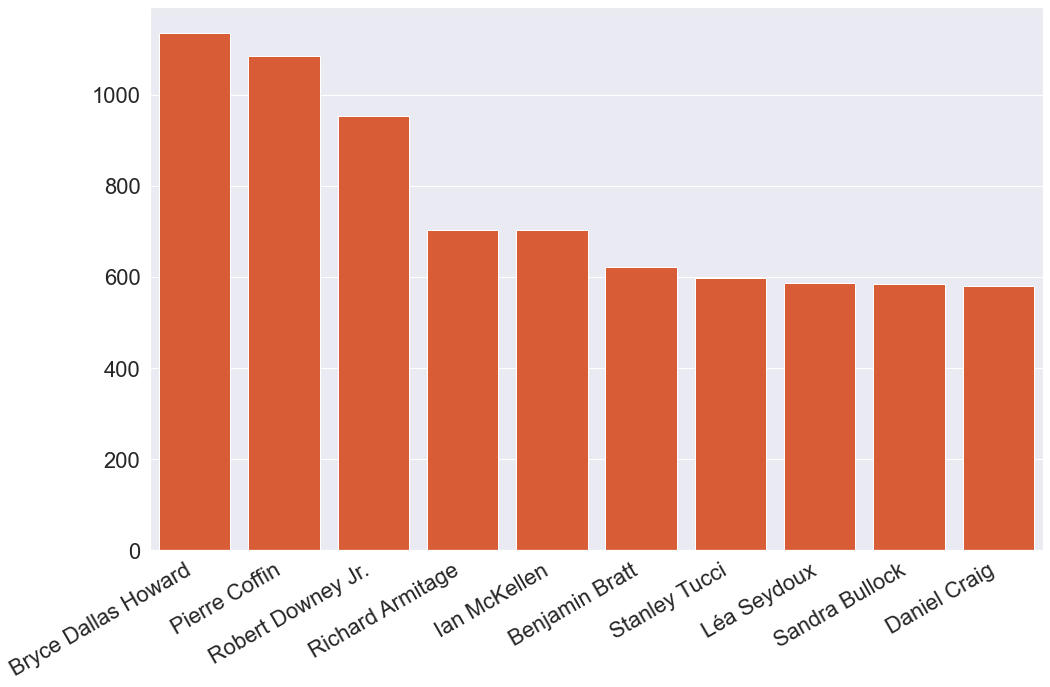

In [99]:
# Include top 10 results
top_actor_analysis = actor_analysis.head(10)
sns.set_style(style='white')

# Create bar plot
sns.set(rc={'figure.figsize':(16,10)}, font_scale=2)
ax1 = sns.barplot(x='primary_name', y='profit', data=top_actor_analysis, color='#F34F1C')
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 30, ha = 'right')
ax1.ticklabel_format(style='plain', axis='y')
ax1.set(xlabel=None)
ax1.set(ylabel=None)

# Save the image
plt.savefig("top_actors.png")

### Most Profitable Directors

In [19]:
director_analysis = filtered_df3.copy()

# Sort by desired category and include relevant columns
director_analysis = director_analysis[director_analysis['category'] == 'director']
director_analysis = director_analysis[['primary_name', 'profit']]

# Divide profit total by one million for increased readability
#director_analysis['profit'] = (director_analysis['profit'] / 1000000).round(0)

# Obtain median profit of all projects they were involved in and sort highest to lowest
director_analysis = director_analysis.groupby('primary_name', as_index=False)['profit'].median().round(0)
director_analysis = director_analysis.sort_values(by='profit', ascending=False)

In [20]:
director_analysis.head(10)

,primary_name,profit
79,Jennifer Lee,1122.0
75,James Wan,987.0
125,Pierre Coffin,929.0
81,Joe Russo,890.0
6,Anthony Russo,890.0
21,Chris Renaud,812.0
28,Colin Trevorrow,719.0
122,Peter Jackson,710.0
12,Bill Condon,588.0
57,Francis Lawrence,565.0


### Director Bar Plot

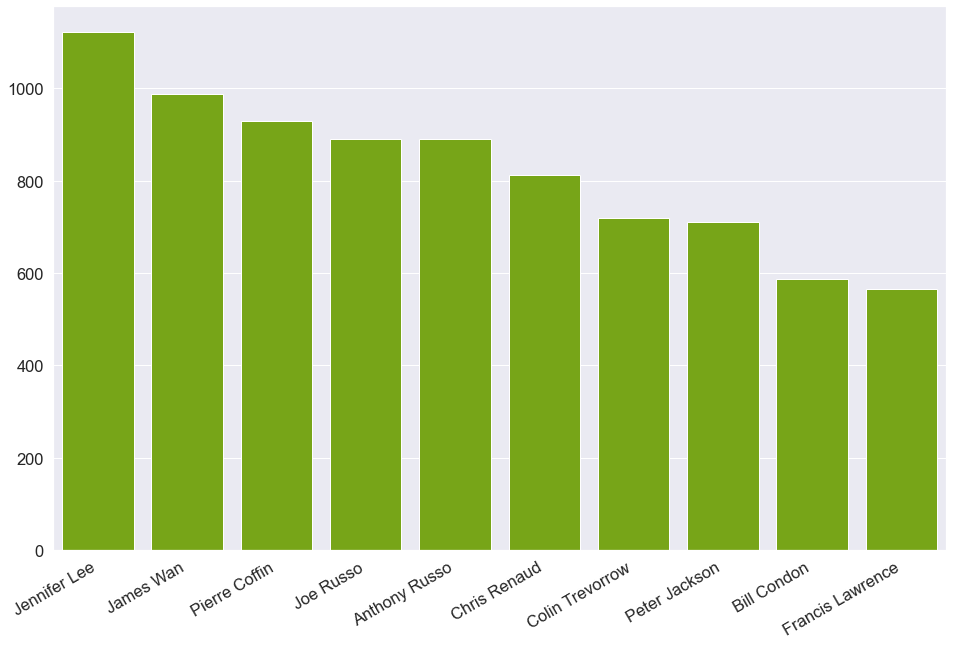

In [92]:
# Include top 10 results
top_director_analysis = director_analysis.head(10)

# Create bar plot
sns.set(rc={'figure.figsize':(16,10)}, font_scale=1.5)
ax2 = sns.barplot(x='primary_name', y='profit', data=top_director_analysis, color='#7FBC00')
ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 30, ha='right')
ax2.ticklabel_format(style='plain', axis='y')
ax2.set(xlabel=None)
ax2.set(ylabel=None)

# Save the image
plt.savefig("top_directors.png")

### Most Profitable Writers

In [22]:
writer_analysis = filtered_df3.copy()

# Sort by desired category and include relevant columns
writer_analysis = writer_analysis[writer_analysis['category'] == 'writer']
writer_analysis = writer_analysis[['primary_name', 'profit']]

# Divide profit total by one million for increased readability
#writer_analysis['profit'] = (writer_analysis['profit'] / 1000000).round(0)

# Obtain median profit of all projects they were involved in and sort highest to lowest
writer_analysis = writer_analysis.groupby('primary_name', as_index=False)['profit'].median().round(0)
writer_analysis = writer_analysis.sort_values(by='profit', ascending=False)

In [23]:
writer_analysis.head(10)

,primary_name,profit
35,Colin Trevorrow,1136.0
34,Cinco Paul,899.0
136,Ken Daurio,899.0
105,Joe Simon,890.0
96,Jeanne-Marie Leprince de Beaumont,844.0
207,Stephen Chbosky,844.0
17,Brian Lynch,812.0
199,Scott Rosenberg,738.0
87,J.R.R. Tolkien,710.0
81,Guillermo del Toro,710.0


### Writer Bar Plot

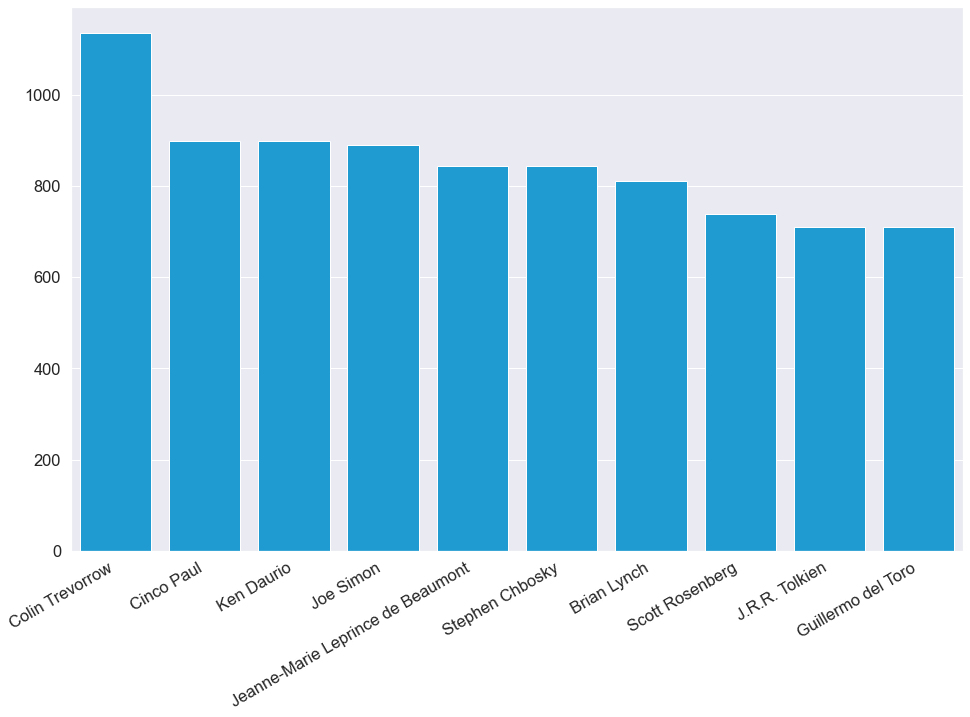

In [90]:
# Include top 10 results
top_writer_analysis = writer_analysis.head(10)

# Create bar plot
sns.set(rc={'figure.figsize':(16,10)}, font_scale=1.5)


ax3 = sns.barplot(x='primary_name', y='profit', data=top_writer_analysis, color='#01A6F0')
ax3.set_xticklabels(ax3.get_xticklabels(),rotation = 30, ha='right')
ax3.ticklabel_format(style='plain', axis='y')
ax3.set(xlabel=None)
ax3.set(ylabel=None)

# Save the image
plt.savefig("top_writers.png")

# Profit & Genres Analysis

After analyzing individuals and their performance based on their profitability and the genres they are associated with, let's look at each genres to find out what most profitable genres are.

### Feature Engineering to add genres 

In [25]:
# spliting the genres by comma and resetting index to prepare tables to merge
joined_df4= joined_df3['genres'].str.split(',', expand=True).reset_index()
joined_df5 = joined_df3.reset_index()

In [26]:
# merging main dataframe table with new table with different genres on each column
df5 = joined_df5.merge(joined_df4, on='index')
df5

,index,primary_title,start_year,runtime_minutes,genres,averagerating,primary_name,category,production_budget,worldwide_gross,profit,profit over budget,0,1,2
0,11204,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Stephen McFeely,writer,300.0,2048.13420,1748.13420,5.827114,Action,Adventure,Sci-Fi
1,11200,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Anthony Russo,director,300.0,2048.13420,1748.13420,5.827114,Action,Adventure,Sci-Fi
2,11195,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Robert Downey Jr.,actor,300.0,2048.13420,1748.13420,5.827114,Action,Adventure,Sci-Fi
3,11196,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Chris Evans,actor,300.0,2048.13420,1748.13420,5.827114,Action,Adventure,Sci-Fi
4,11197,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Jack Kirby,writer,300.0,2048.13420,1748.13420,5.827114,Action,Adventure,Sci-Fi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12716,13056,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Stan Lee,writer,350.0,149.76235,-200.23765,-0.572108,Action,Adventure,Sci-Fi
12717,13057,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,James McAvoy,actor,350.0,149.76235,-200.23765,-0.572108,Action,Adventure,Sci-Fi
12718,13058,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Michael Fassbender,actor,350.0,149.76235,-200.23765,-0.572108,Action,Adventure,Sci-Fi
12719,13059,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Chris Claremont,writer,350.0,149.76235,-200.23765,-0.572108,Action,Adventure,Sci-Fi


In [27]:
#renaming genres' columns
df5.rename(columns = {0:'genres 1', 1:'genres 2', 2: 'genres 3'}, inplace=True)
df5

,index,primary_title,start_year,runtime_minutes,genres,averagerating,primary_name,category,production_budget,worldwide_gross,profit,profit over budget,genres 1,genres 2,genres 3
0,11204,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Stephen McFeely,writer,300.0,2048.13420,1748.13420,5.827114,Action,Adventure,Sci-Fi
1,11200,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Anthony Russo,director,300.0,2048.13420,1748.13420,5.827114,Action,Adventure,Sci-Fi
2,11195,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Robert Downey Jr.,actor,300.0,2048.13420,1748.13420,5.827114,Action,Adventure,Sci-Fi
3,11196,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Chris Evans,actor,300.0,2048.13420,1748.13420,5.827114,Action,Adventure,Sci-Fi
4,11197,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,Jack Kirby,writer,300.0,2048.13420,1748.13420,5.827114,Action,Adventure,Sci-Fi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12716,13056,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Stan Lee,writer,350.0,149.76235,-200.23765,-0.572108,Action,Adventure,Sci-Fi
12717,13057,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,James McAvoy,actor,350.0,149.76235,-200.23765,-0.572108,Action,Adventure,Sci-Fi
12718,13058,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Michael Fassbender,actor,350.0,149.76235,-200.23765,-0.572108,Action,Adventure,Sci-Fi
12719,13059,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,Chris Claremont,writer,350.0,149.76235,-200.23765,-0.572108,Action,Adventure,Sci-Fi


In [28]:
# creating new table showing each genres of each movie and corresponding profit
df6 = df5.melt(value_vars=['genres 1', 'genres 2', 'genres 3'], id_vars='profit' )

#dropping None values
df6 = df6.dropna(subset=['value'], axis=0)
df6

,profit,variable,value
0,1748.13420,genres 1,Action
1,1748.13420,genres 1,Action
2,1748.13420,genres 1,Action
3,1748.13420,genres 1,Action
4,1748.13420,genres 1,Action
...,...,...,...
38158,-200.23765,genres 3,Sci-Fi
38159,-200.23765,genres 3,Sci-Fi
38160,-200.23765,genres 3,Sci-Fi
38161,-200.23765,genres 3,Sci-Fi


In [29]:
#defining function to return profit median for each genres
def mean_genres(i):
    genres = joined_df3.loc[joined_df3['genres'].str.contains(i)]
    
    return genres['profit'].median().round(decimals=2)

In [30]:
# creating a list of unique individual genres
joined_df6= joined_df3['genres'].str.split(',', expand=True)
genres_types=[]
for n in range(len(joined_df4)):
    for i in joined_df6.iloc[n]:
        if i not in genres_types:
            genres_types.append(i)
genres_types = list(filter(None, genres_types))
genres_types

['Action',
 'Adventure',
 'Sci-Fi',
 'Crime',
 'Thriller',
 'Animation',
 'Comedy',
 'Family',
 'Fantasy',
 'Musical',
 'Drama',
 'Romance',
 'Biography',
 'Music',
 'Horror',
 'Western',
 'History',
 'Mystery',
 'War',
 'Sport',
 'Documentary']

In [31]:
# creating a dict with genres and their profit over budget ratio median value
genres_ = {}

for i in genres_types:
    genres_[i] = mean_genres(i)
genres_        


{'Action': 56.76,
 'Adventure': 122.5,
 'Sci-Fi': 83.92,
 'Crime': 12.84,
 'Thriller': 26.63,
 'Animation': 160.71,
 'Comedy': 34.4,
 'Family': 55.23,
 'Fantasy': 50.82,
 'Musical': 42.53,
 'Drama': 11.48,
 'Romance': 11.0,
 'Biography': 17.32,
 'Music': 9.88,
 'Horror': 25.17,
 'Western': 0.1,
 'History': 5.15,
 'Mystery': 29.15,
 'War': 0.1,
 'Sport': 14.22,
 'Documentary': 0.23}

### Production Budget Distribution

In [32]:
# setting the figure size
sns.set(rc={'figure.figsize':(30,15)})

<ipython-input-100-0d0c92480ace>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(ax3.get_xticks(), size = 25)
<ipython-input-100-0d0c92480ace>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(ax3.get_yticks(), size = 25)


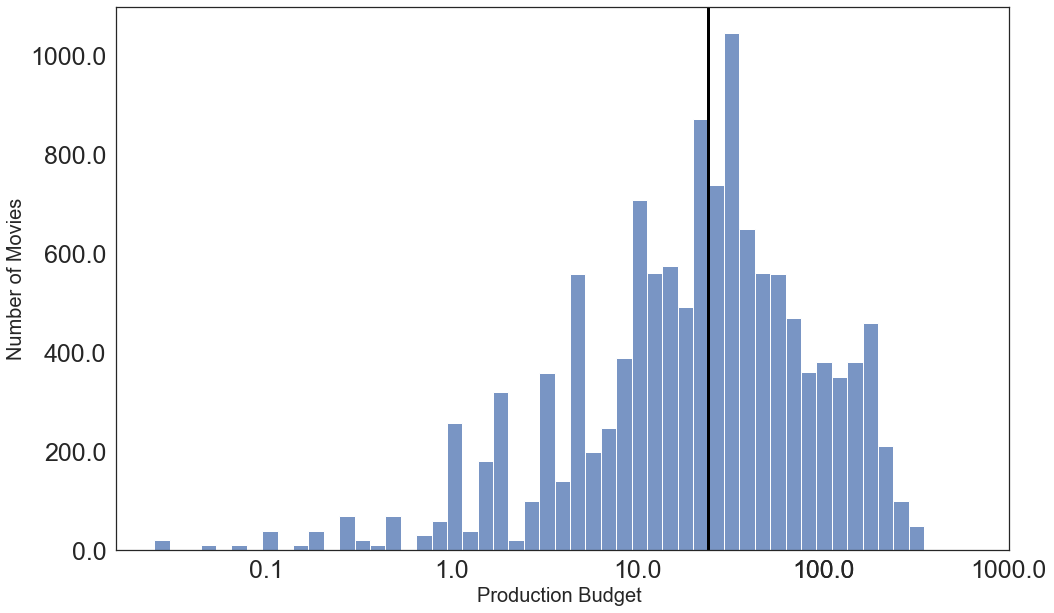

In [100]:
# adding histogram of production budget distribution
sns.set_style(style='white')

ax3 = sns.histplot(x=joined_df3['production_budget'], bins= 50, log_scale=True)

plt.axvline(x=joined_df3['production_budget'].median(),
            color='black', linewidth=3)

plt.xlabel("Production Budget ", size=20)
plt.ylabel("Number of Movies", size=20)

ax3.set_xticklabels(ax3.get_xticks(), size = 25)
ax3.set_yticklabels(ax3.get_yticks(), size = 25)

ax3.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax3.set_xticks([0.1, 1, 100, 10,100, 1000])
plt.savefig("Production_budget_distribution.png");

### Profit Distribution

C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-101-8c1231126742>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(ax4.get_xticks(), size = 30)
<ipython-input-101-8c1231126742>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_yticklabels(ax4.get_yticks(), size = 30)


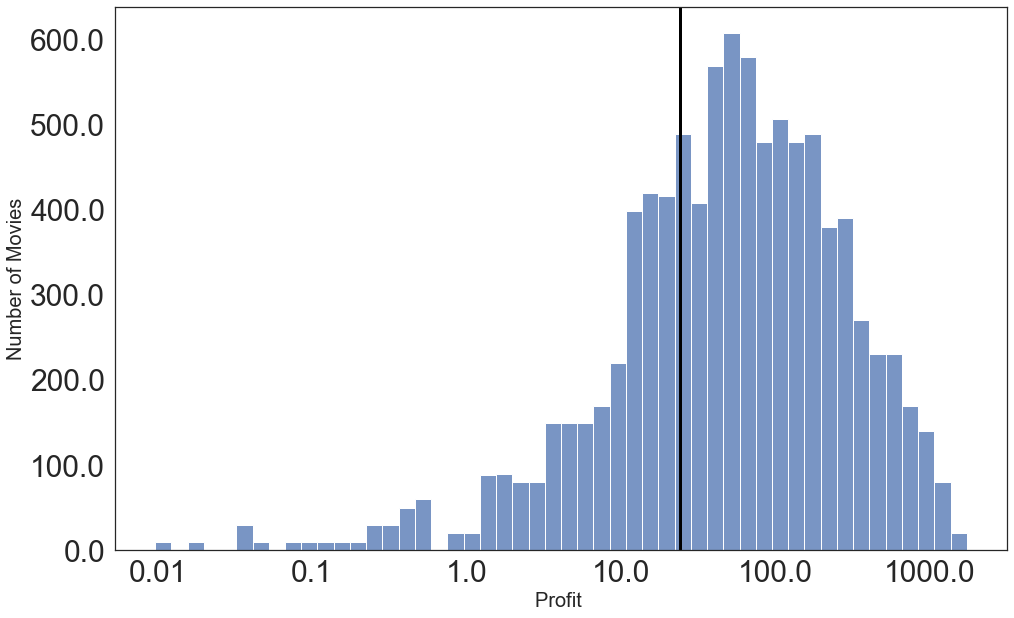

In [101]:
# adding histogram of profit budget distribution
sns.set_style(style='white')

ax4 = sns.histplot(x=joined_df3['profit'], bins=50, log_scale=True)

plt.axvline(x=joined_df3['profit'].median(),
            color='black', linewidth=3)

plt.xlabel("Profit ", size=20)
plt.ylabel("Number of Movies", size=20)

ax4.set_xticklabels(ax4.get_xticks(), size = 30)
ax4.set_yticklabels(ax4.get_yticks(), size = 30)
plt.savefig("Profit_distribution.png");

### Production Budget vs Profit

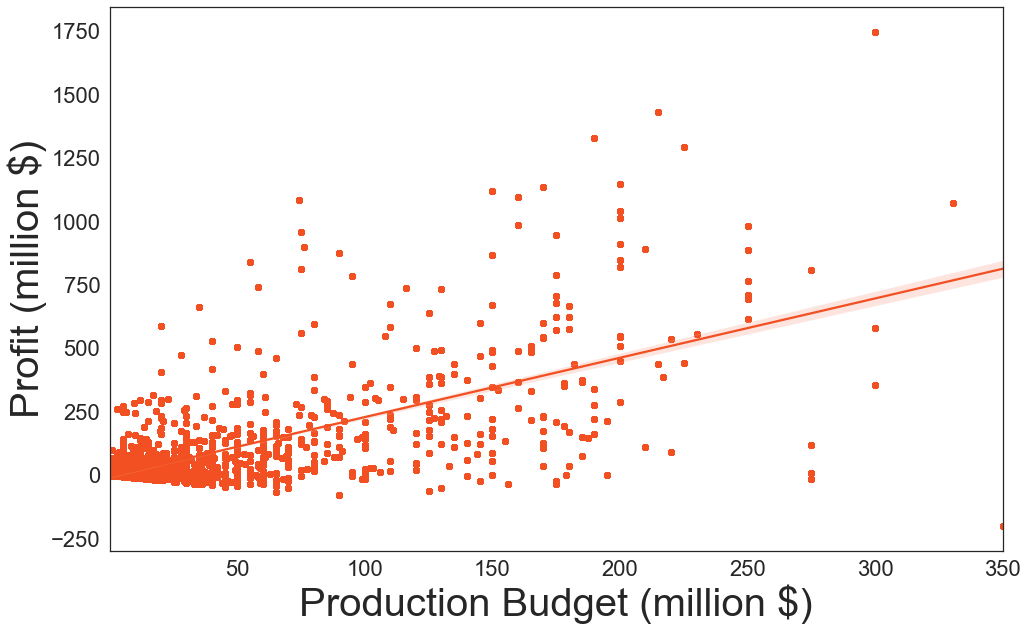

In [104]:
# scatter plot to see the relationship between production budget and profitsns.

ax6 = sns.regplot(x=joined_df3['production_budget'], y = joined_df3['profit'], color = '#F25022'
)
plt.xlabel("Production Budget (million $)", size=40)
plt.ylabel("Profit (million $)", size=40)
plt.savefig("Production_budget_Profit.png");

### Top Movies Bar Plot 

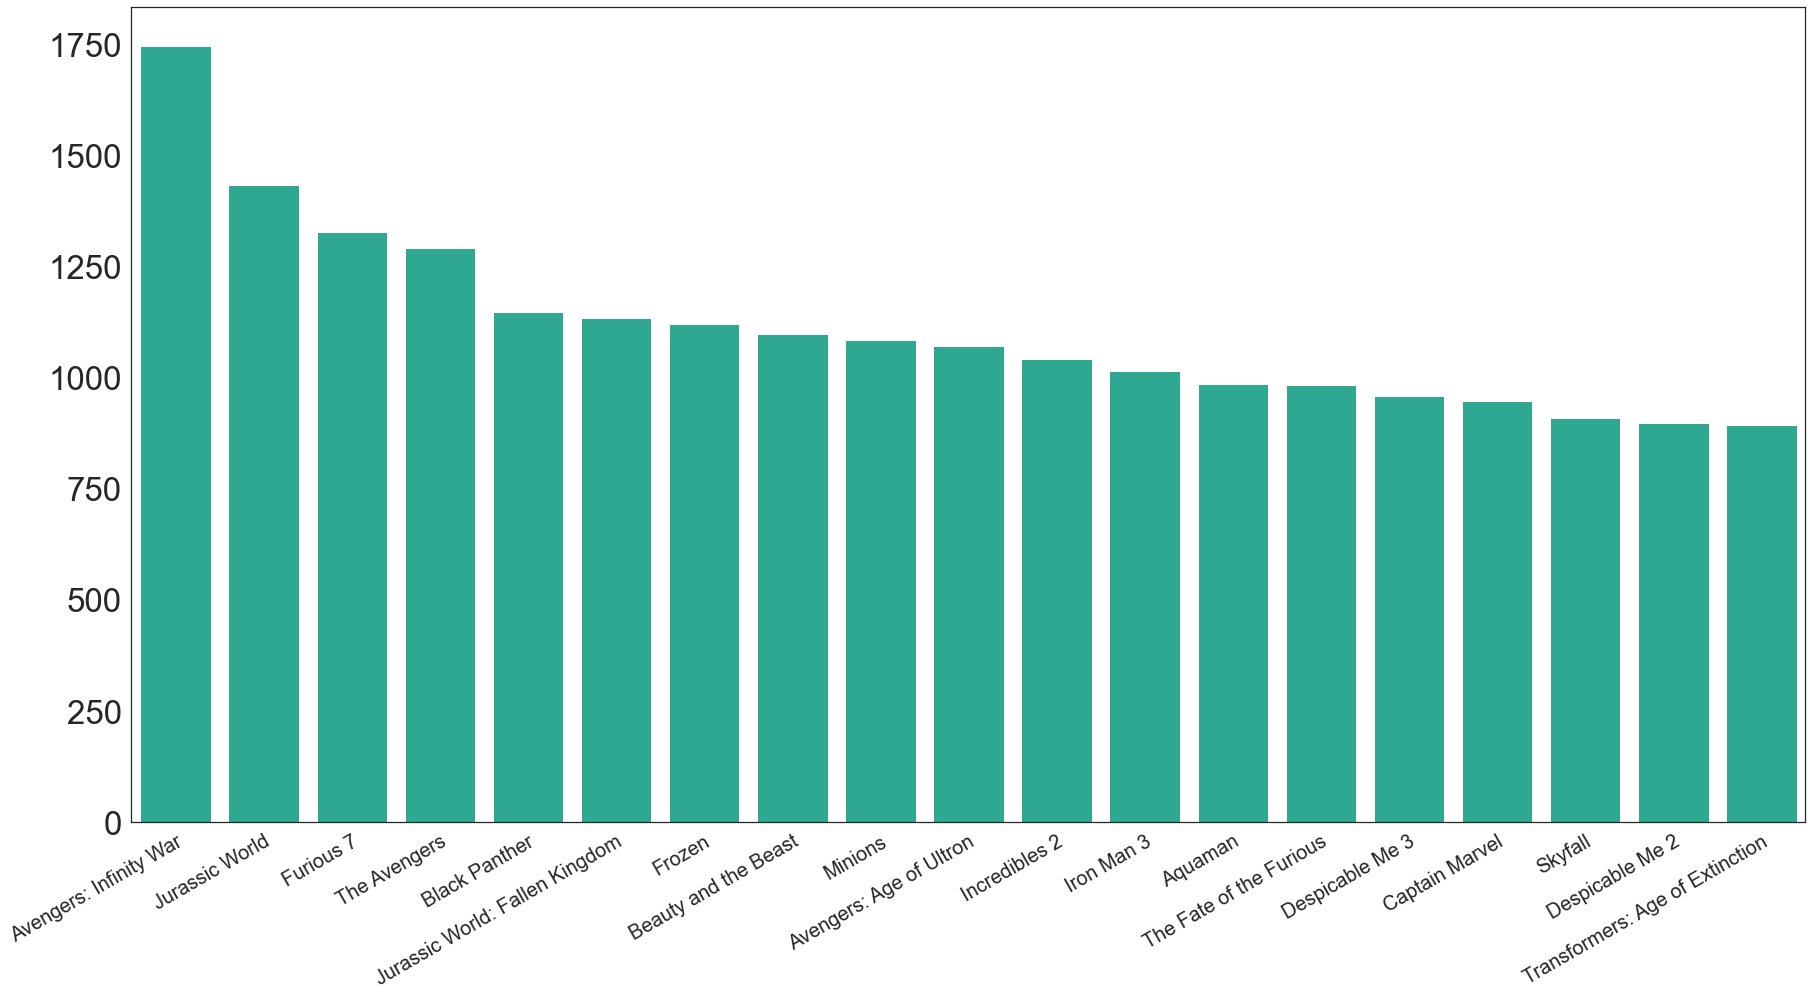

In [112]:
# sorting the data set based on profit
df8 = joined_df3.drop(['category', 'primary_name'], axis = 1)
df8 = df8.drop_duplicates()

# bar chart to see top 20 movies based on profit
sns.set(rc={'figure.figsize':(30,15)}, font_scale=3)
sns.set_style(style='white')

ax7 = sns.barplot(x=df8['primary_title'][:20], y=df8['profit'][:20], color = "#1ABC9C")
ax7.set_xticklabels(ax7.get_xticklabels(),rotation = 30, fontsize= 20,  ha="right", rotation_mode="anchor")
plt.xlabel("Movies ", size=40)
plt.ylabel("Profit (million $)", size=40)
ax7.set(xlabel=None)
ax7.set(ylabel=None)

plt.savefig("Top_movies.png")


### Top Genres Bar Plot


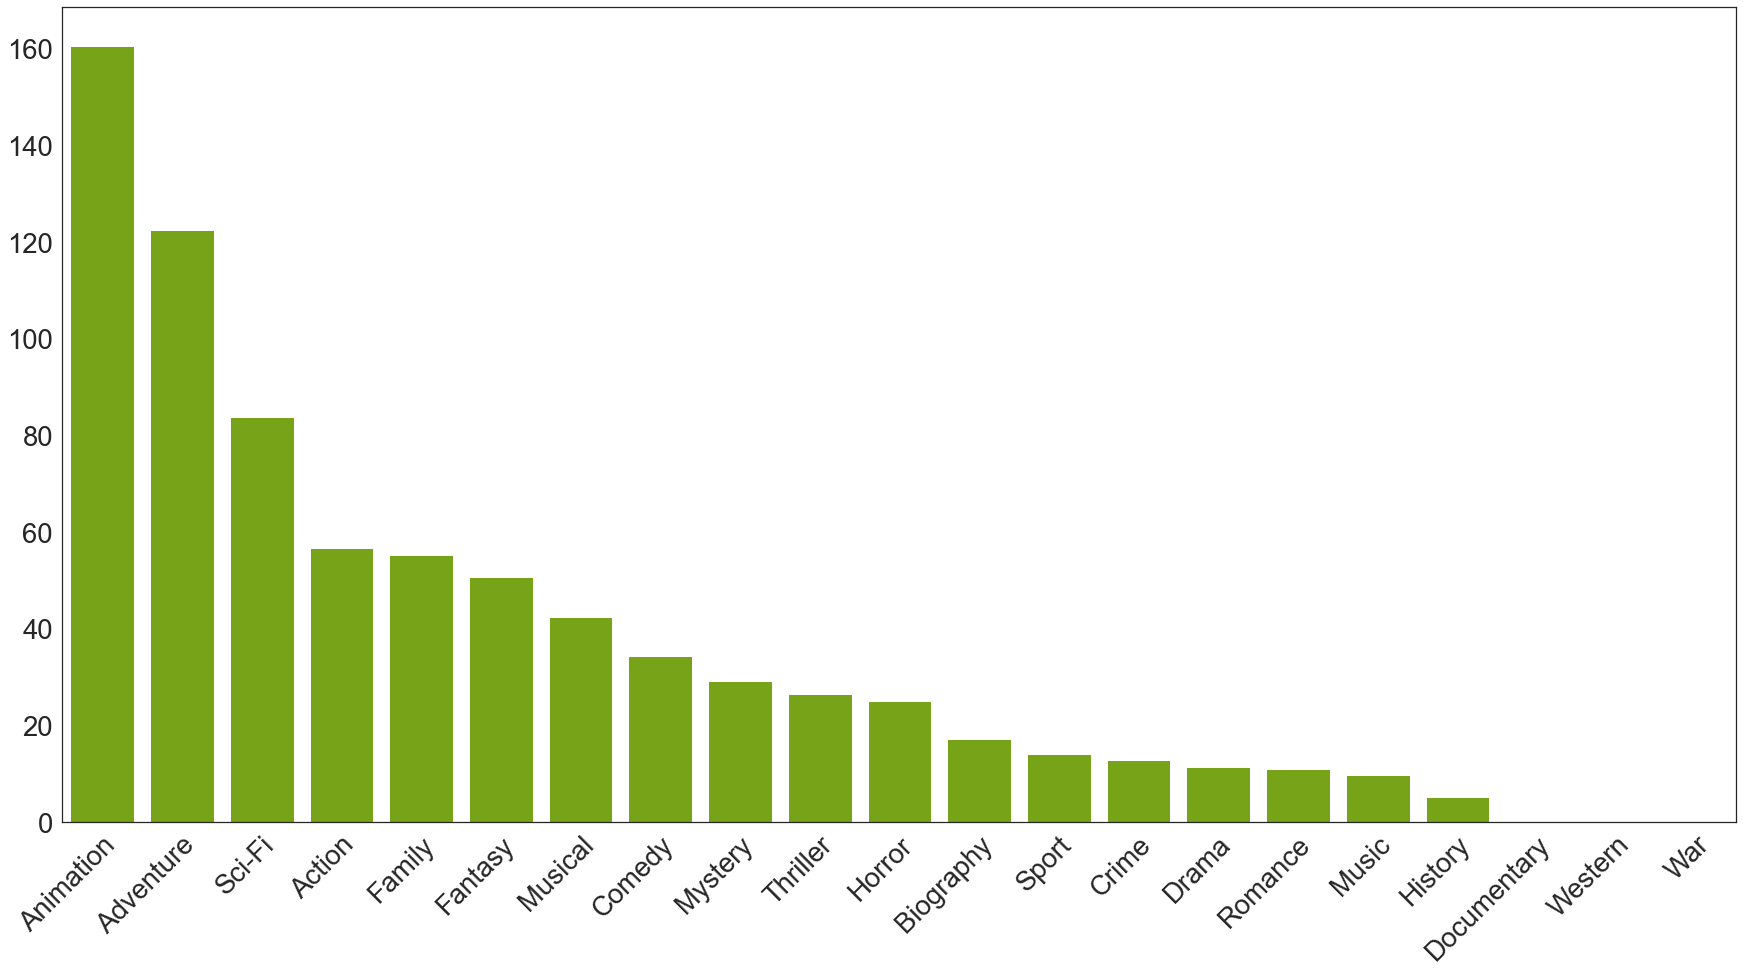

In [116]:
keyss = list(genres_.keys())
vals = [float(genres_[k]) for k in keyss]

sorted_df = pd.DataFrame({"Genres": keyss, "Profit": vals})

sns.set(font_scale=2.5)
sns.set_style(style='white')

ax2=sns.barplot(x='Genres',y='Profit',data=sorted_df,order=sorted_df.sort_values('Profit',ascending=False).Genres,color="#7FBA00\
")
ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 45, ha="right", rotation_mode="anchor");

plt.xlabel("Genres", size=40)
plt.ylabel("Profit (million $)", size=40)
ax2.set(xlabel=None)
ax2.set(ylabel=None)
plt.savefig("Top_genres_individuals.png");

### Top Genres Box Plot

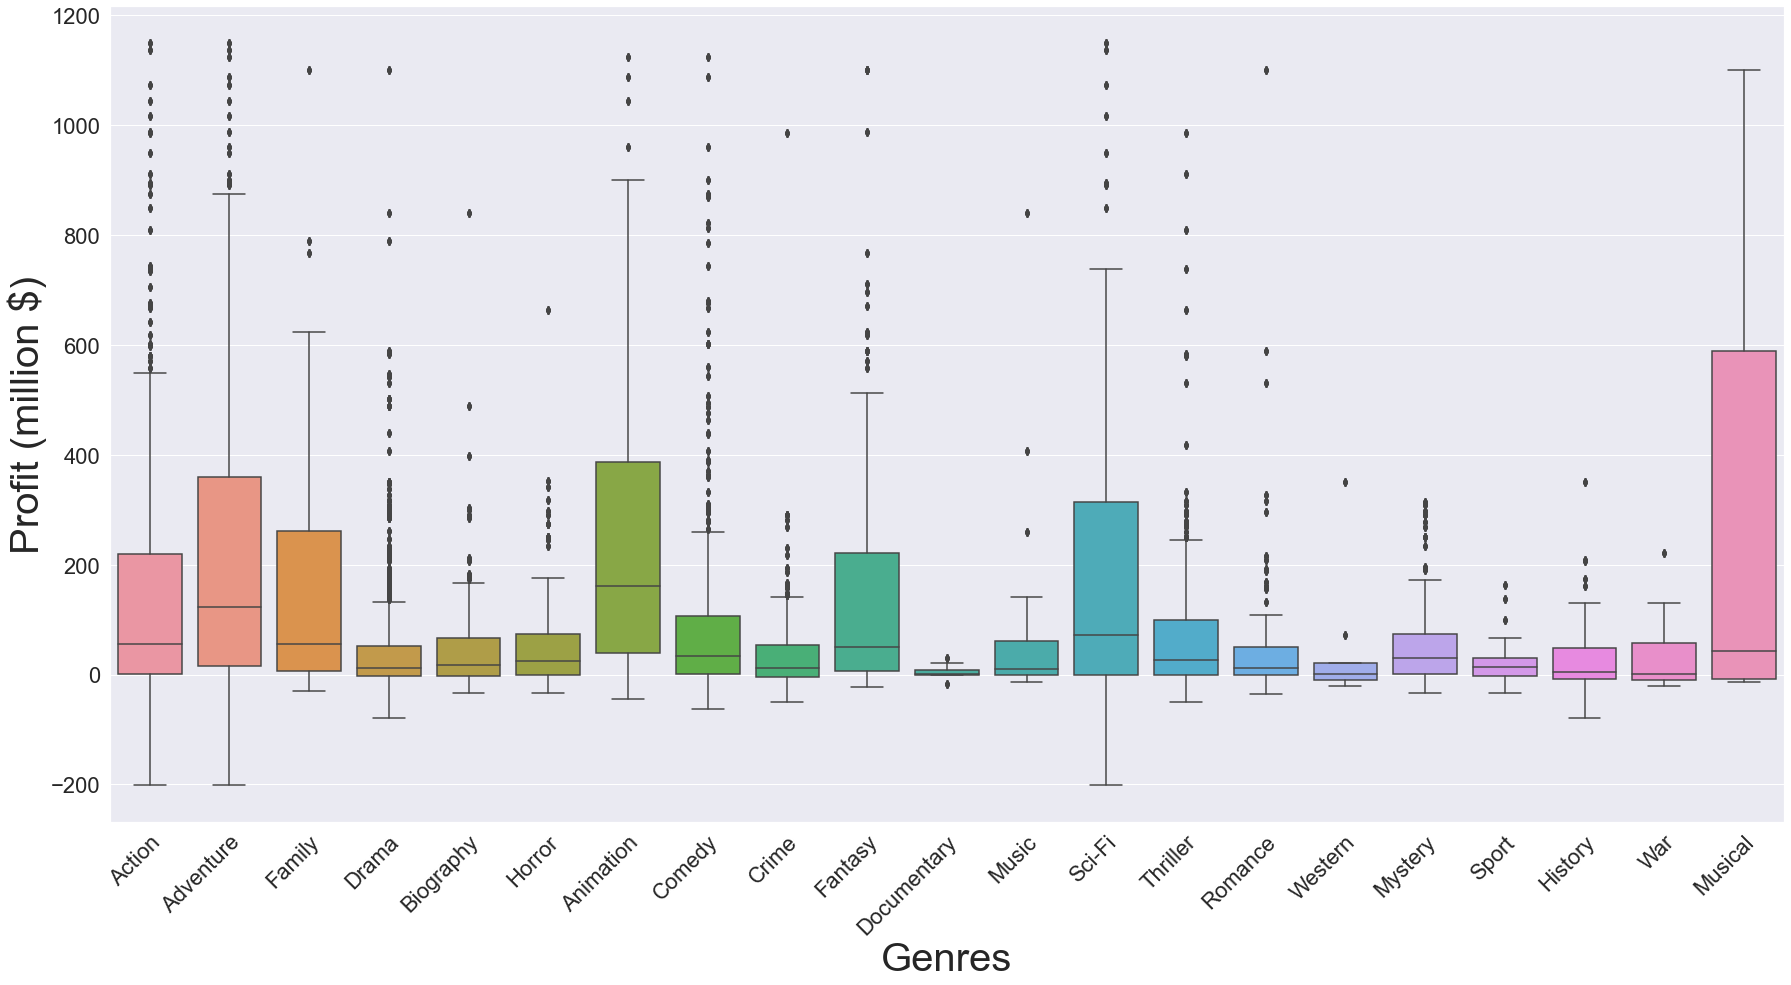

In [38]:
#filtering data to avoid seeing absolute outliers
df7 = df6[df6['profit'] < 1200]

box_plot = sns.boxplot(x=df7['value'], y=df7['profit'])
box_plot.set(xlabel="Genres", ylabel="Profit (million $)")
box_plot.set_xticklabels(box_plot.get_xticklabels(),rotation = 45, ha="right", rotation_mode="anchor")

plt.xlabel("Genres", size=40)
plt.ylabel("Profit (million $)", size=40)
plt.savefig("Top_genres_boxplot.png");

### Ideal Budget

How much should be spent on production budget? Higher budgets are inherently riskier, but being able to afford a talented team can boost profits. The median of the top 100 films will show a good starting point to recommend to the stakeholder because it is less affected by extremely low and high budget outliers.

In [39]:
top_100_profit = df8[:100]
top_100_profit['production_budget'].median()

160.0

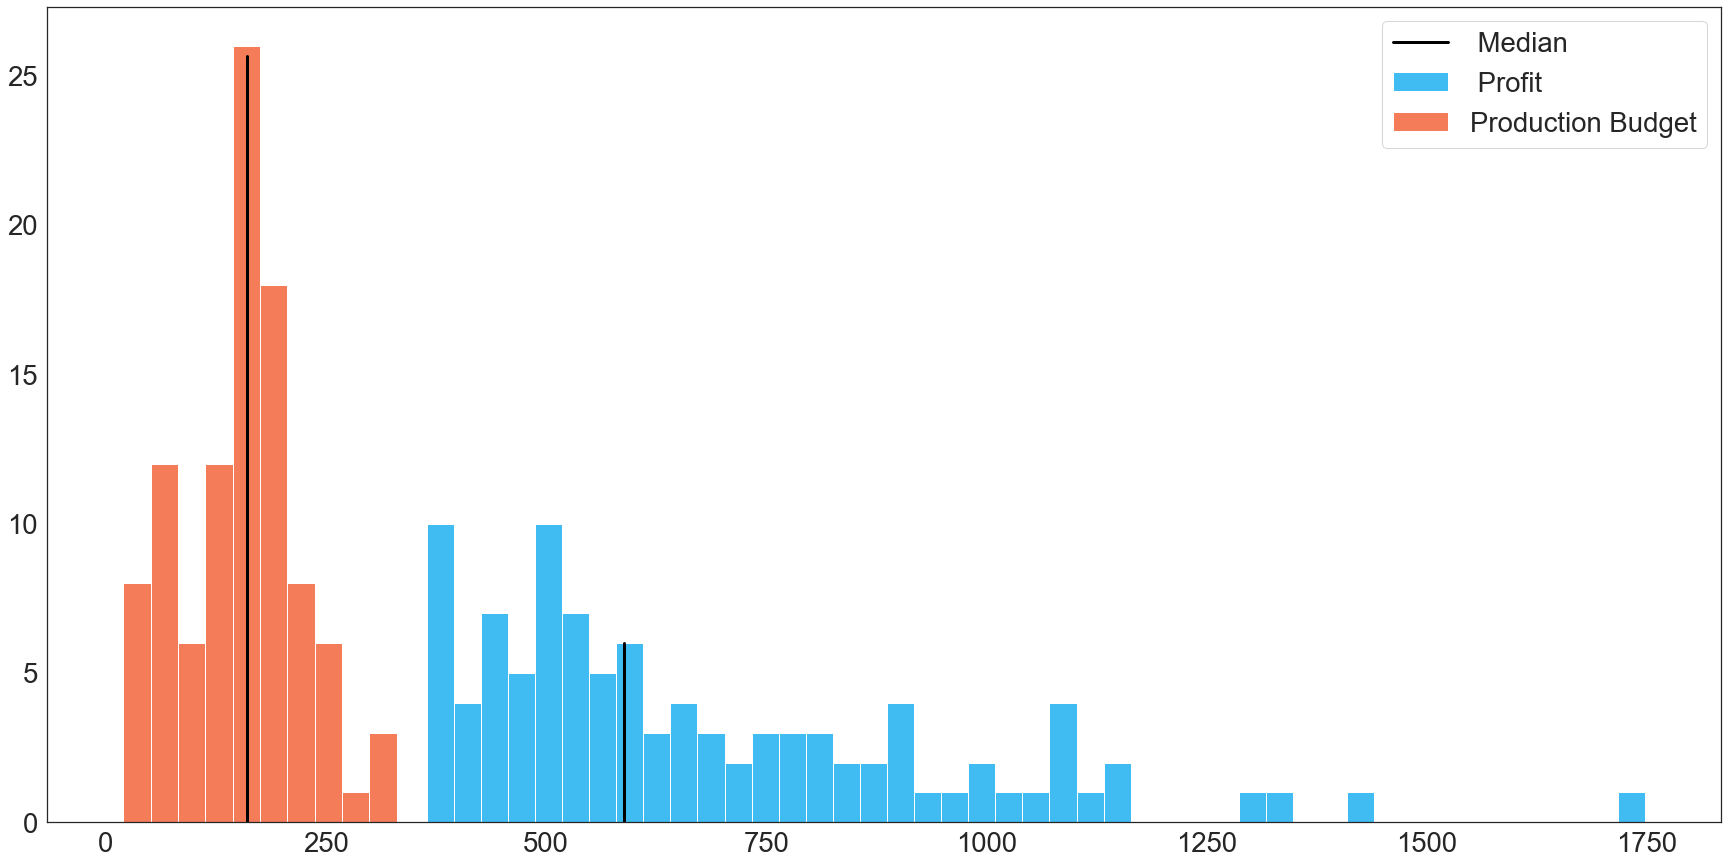

In [114]:
# Create histogram of top 100 profit
sns.set(rc={'figure.figsize':(30,15)}, font_scale=2.5)
sns.set_style(style='white')


ax8 = sns.histplot(x=top_100_profit['profit'], bins=45, color='#01A6F0',label=' Profit')
ax9 = sns.histplot(x=top_100_profit['production_budget'], bins=10, color='#F25022', label='Production Budget')
# Create a line at the median
plt.axvline(x=top_100_profit['profit'].median(), ymax=0.22, label=' Median',
            color='black', linewidth=3)
plt.axvline(x=top_100_profit['production_budget'].median(), ymax=0.94, 
            color='black', linewidth=3)
ax8.set(xlabel=None)
ax8.set(ylabel=None)
ax8.legend();

[Text(0, 0.5, '')]

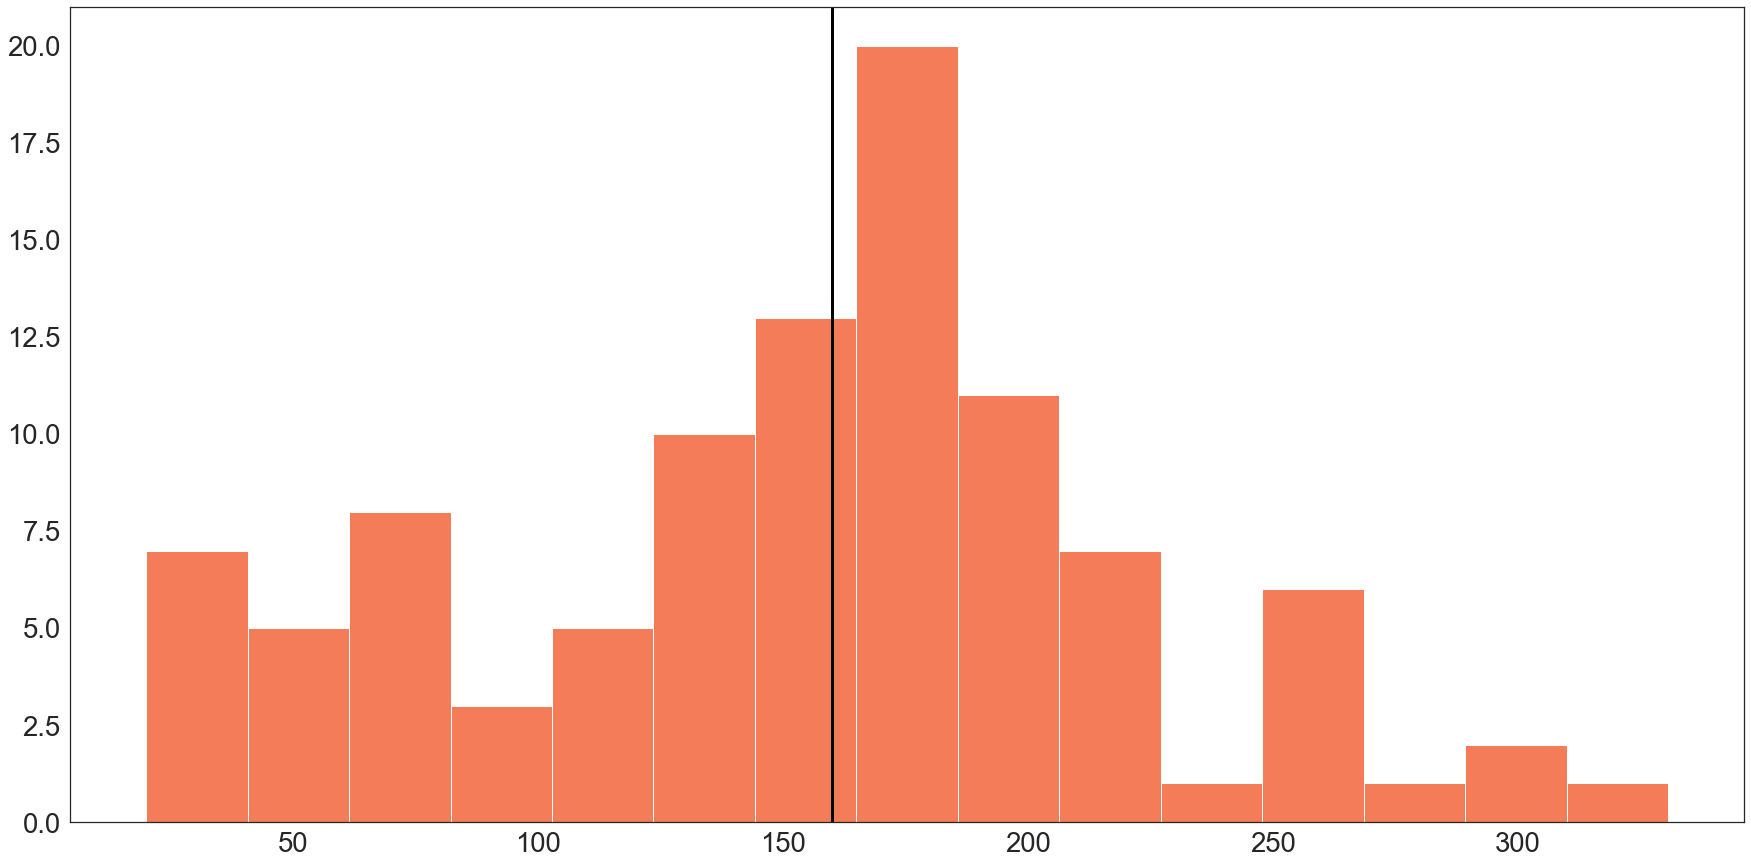

In [115]:
# Create histogram of top 100 movie budgets
ax9 = sns.histplot(x=top_100_profit['production_budget'], bins=15, color='#F25022')
sns.set_style(style='white')


# Create a line at the median
plt.axvline(x=top_100_profit['production_budget'].median(),
            color='black', linewidth=3)
ax9.set(xlabel=None)
ax9.set(ylabel=None)

## Conclusions

From our analysis, we recommend going with consistently profitable actors, actresses, directors, and writers found in the top ten lists.

The ideal genres to be in are Animation, Adventure, Sci-fi, Action, and Family. Animation is extremely profitable according to the data, but starting an animation studio requires a different set of skilled professionals than a traditional film and we would need to work with the stakeholder to see if an animated project is feasible. Otherwise, there appears to be a high demand for Adventure, Sci-fi, and Action films, and making the movie family-friendly could possibly create a broader appeal.

There is a positive correlation between production budget and profit, which suggests that a budget that is on the higher side would be ideal to maximize profits. The median budget of the top 100 most profitable films in our data set was $160 million. A budget around this number would most likely be a strong bet.